# Image dataset preprocessing using SageMaker

In [94]:
import sagemaker, boto3, json
from sagemaker.session import Session

sagemaker_session = Session()
aws_role = sagemaker_session.get_caller_identity_arn()
aws_region = boto3.Session().region_name
sess = sagemaker.Session()
s3_resource = boto3.resource('s3', region_name=aws_region)
bucket = s3_resource.Bucket('isicbucket')

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


## Train val test split

In [3]:
import pandas as pd

metadata = pd.read_csv("../ISICmerge2019_2020_remove_dup_img.csv")
metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57729 entries, 0 to 57728
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   image_id                       57729 non-null  object 
 1   patient_id                     55650 non-null  object 
 2   target                         57729 non-null  object 
 3   source                         57729 non-null  object 
 4   sex                            57310 non-null  object 
 5   age_approx                     57254 non-null  float64
 6   benign_malignant               57729 non-null  object 
 7   anatom_site_general_challenge  54597 non-null  object 
dtypes: float64(1), object(7)
memory usage: 3.5+ MB


{'actinic keratoses': 859,
 'basal cell carcinoma': 3316,
 'dermatofibroma': 239,
 'keratosis': 2610,
 'melanoma': 5088,
 'nevus': 18042,
 'squamous cell carcinoma': 628,
 'unknown': 26694,
 'vascular skin': 253}

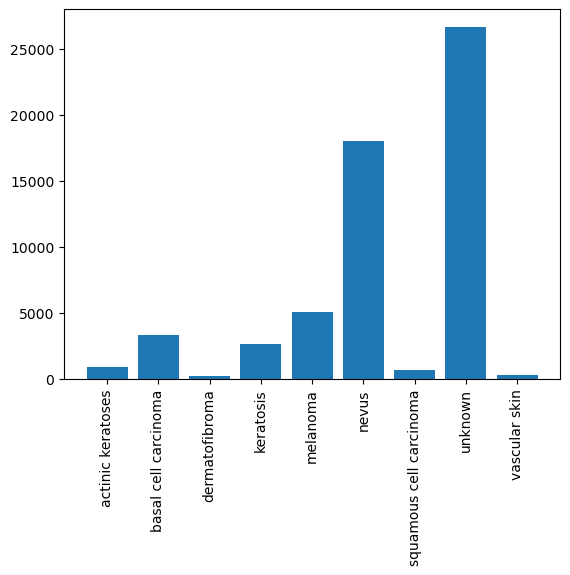

In [4]:
import numpy as np
import matplotlib.pyplot as plt

classes, counts = np.unique(metadata.target, return_counts=True)
plt.bar(classes, counts)
plt.xticks(rotation=90)
class_counts_dict = dict(zip(classes, counts))
class_counts_dict

In [5]:
metadata['train'] = False
metadata['val'] = False
metadata['test'] = False
metadata.head()

,image_id,patient_id,target,source,sex,age_approx,benign_malignant,anatom_site_general_challenge,train,val,test
0,ISIC_2637011.jpg,IP_7279968,unknown,ISIC2020,male,45.0,benign,head/neck,False,False,False
1,ISIC_0015719.jpg,IP_3075186,unknown,ISIC2020,female,45.0,benign,upper extremity,False,False,False
2,ISIC_0052212.jpg,IP_2842074,nevus,ISIC2020,female,50.0,benign,lower extremity,False,False,False
3,ISIC_0068279.jpg,IP_6890425,unknown,ISIC2020,female,45.0,benign,head/neck,False,False,False
4,ISIC_0074268.jpg,IP_8723313,unknown,ISIC2020,female,55.0,benign,upper extremity,False,False,False


### Randomly choose 10% of images from each class for test and val

In [31]:
np.random.seed(0)

In [32]:
metadata['test'] = False
test_split = 0.1

for class_ in classes:
    split_cardinality = round(class_counts_dict[class_] * test_split)
    split_image_names = np.random.choice(metadata[(metadata.target == class_) & (metadata.val == False)].image_id, 
                                         size=split_cardinality, 
                                         replace=False)
    metadata.loc[(metadata.image_id.isin(split_image_names)) & (metadata.val == False), 'test'] = True

In [33]:
metadata['val'] = False
val_split = 0.1

for class_ in classes:
    split_cardinality = round(class_counts_dict[class_] * val_split)
    split_image_names = np.random.choice(metadata[(metadata.target == class_) & (metadata.test == False)].image_id,
                                         size=split_cardinality, 
                                         replace=False)
    metadata.loc[(metadata.image_id.isin(split_image_names)) & (metadata.test == False), 'val'] = True

In [38]:
metadata['train'] = True
metadata.loc[(metadata.val == True) | (metadata.test == True), 'train'] = False

In [72]:
metadata.head()

,image_id,patient_id,target,source,sex,age_approx,benign_malignant,anatom_site_general_challenge,train,val,test
0,ISIC_2637011.jpg,IP_7279968,unknown,ISIC2020,male,45.0,benign,head/neck,False,True,False
1,ISIC_0015719.jpg,IP_3075186,unknown,ISIC2020,female,45.0,benign,upper extremity,True,False,False
2,ISIC_0052212.jpg,IP_2842074,nevus,ISIC2020,female,50.0,benign,lower extremity,True,False,False
3,ISIC_0068279.jpg,IP_6890425,unknown,ISIC2020,female,45.0,benign,head/neck,False,True,False
4,ISIC_0074268.jpg,IP_8723313,unknown,ISIC2020,female,55.0,benign,upper extremity,True,False,False


In [39]:
metadata.groupby('target').sum()[['train', 'val', 'test']]

,train,val,test
target,,,
actinic keratoses,687,86,86
basal cell carcinoma,2652,332,332
dermatofibroma,191,24,24
keratosis,2088,261,261
melanoma,4070,509,509
nevus,14434,1804,1804
squamous cell carcinoma,502,63,63
unknown,21356,2669,2669
vascular skin,203,25,25


In [99]:
metadata.to_csv("ISIC_Metadata_Labels_Splits.csv")

### Functions to Read and Write images to s3 without downloading locally

In [40]:
from PIL import Image
from io import BytesIO

def read_image_from_s3(key, bucket=bucket):
    """Load image file from s3.

    Parameters
    ----------
    bucket: string
        Bucket name
    key : string
        Path in s3

    Returns
    -------
    np array
        Image array
    """
    
    object = bucket.Object(key)
    response = object.get()
    file_stream = response['Body']
    im = Image.open(file_stream)
    return np.array(im)

def write_image_to_s3(img_array, key, bucket=bucket):
    """Write an image array into S3 bucket

    Parameters
    ----------
    bucket: string
        Bucket name
    key : string
        Path in s3

    Returns
    -------
    None
    """
    
    object = bucket.Object(key)
    file_stream = BytesIO()
    im = Image.fromarray(img_array)
    im.save(file_stream, format='jpeg')
    object.put(Body=file_stream.getvalue())

### Test read_image_from_s3

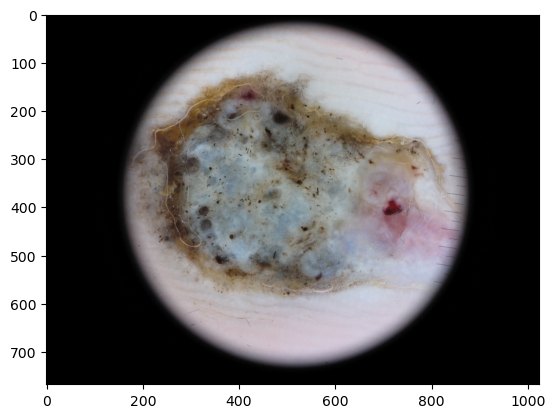

In [44]:
image = read_image_from_s3("ISIC_Raw_Images/ISIC_0000290.jpg")
plt.imshow(image)

In [45]:
!pip install opencv-python-headless


[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


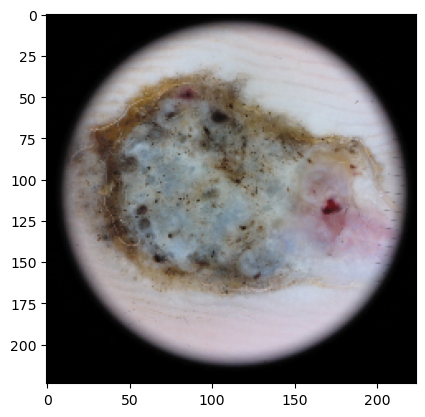

In [46]:
import cv2

# square center crop
height, width = image.shape[:-1]
if width > height:
    image = image[:, (width-height)//2:(width+height)//2, :]
elif width < height:
    image = image[(height-width)//2:(height+width)//2, :, :]

# resize (224x224)
image = cv2.resize(image, dsize=(224, 224))
plt.imshow(image)

## Move preprocessed files to new filestructure

In [98]:
import botocore
from botocore.errorfactory import ClientError

s3 = boto3.client('s3')

for index, row in metadata.iterrows():
    source_path = f"isicbucket/preprocessed/preprocess_ps_224/{row.target}/{row.image_id}"
    split = row.index[np.where(row == True)[0]].values[0]
    dest_path = f"preprocessed/224x224_center_crop/{split}/{row.target}/{row.image_id}"
    
    # Check if image already exists in destination
    try:
        s3.head_object(Bucket='isicbucket', Key=dest_path)
    except botocore.exceptions.ClientError as e:
        if e.response['Error']['Code'] == "404":
            # The image does not exist. Continue with copy.
            s3_resource.Object('isicbucket', dest_path).copy_from(CopySource=source_path)
        else:
            # Something else has gone wrong.
            raise

    #s3_resource.Object('isicbucket', dest_path).copy_from(CopySource=source_path)
    # Print progress info
    if index % 5000 == 0:
        print(f"{index} images moved")

0 images moved


KeyboardInterrupt: 